In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm 
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.metrics import confusion_matrix
import seaborn as sns





In [3]:
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism from scratch.
    Computes attention scores between all positions in the sequence.
    """
    def __init__(self, embed_dim, num_heads):
        """
        Args:
            embed_dim: Dimension of input embeddings
            num_heads: Number of attention heads for Multi-Head Attention
        """
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Linear projections for Q, K, V
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        
        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x, mask=None):
        """
        Forward pass for self-attention.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)
            mask: Optional mask tensor
            
        Returns:
            Output tensor of shape (batch_size, seq_len, embed_dim)
        """
        batch_size, seq_len, embed_dim = x.shape
        
        # Generate Q, K, V matrices
        Q = self.query(x)  # (batch_size, seq_len, embed_dim)
        K = self.key(x)    # (batch_size, seq_len, embed_dim)
        V = self.value(x)  # (batch_size, seq_len, embed_dim)
        
        # Reshape for multi-head attention: (batch_size, num_heads, seq_len, head_dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Calculate attention scores: QK^T / sqrt(d_k)
        # Using torch.matmul for matrix multiplication
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        
        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention weights to V: Attention(Q,K,V) = softmax(QK^T/sqrt(d_k))V
        attended = torch.matmul(attention_weights, V)
        # Shape: (batch_size, num_heads, seq_len, head_dim)
        
        # Reshape back: (batch_size, seq_len, embed_dim)
        attended = attended.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        
        # Apply output projection
        output = self.out_proj(attended)
        
        return output, attention_weights


In [4]:

class LayerNorm(nn.Module):
    """
    Layer Normalization from scratch.
    Normalizes inputs across the feature dimension for each sample independently.
    Formula: y = (x - mean) / sqrt(variance + eps) * gamma + beta
    """
    def __init__(self, embed_dim, eps=1e-6):
        """
        Args:
            embed_dim: Dimension of input embeddings
            eps: Small constant for numerical stability
        """
        super(LayerNorm, self).__init__()
        self.eps = eps
        # Learnable parameters: gamma (scale) and beta (shift)
        self.gamma = nn.Parameter(torch.ones(embed_dim))
        self.beta = nn.Parameter(torch.zeros(embed_dim))
        
    def forward(self, x):
        """
        Forward pass for layer normalization.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)
            
        Returns:
            Normalized tensor of shape (batch_size, seq_len, embed_dim)
        """
        # Calculate mean across the last dimension (embed_dim)
        mean = x.mean(dim=-1, keepdim=True)  # (batch_size, seq_len, 1)
        
        # Calculate variance across the last dimension
        variance = x.var(dim=-1, keepdim=True, unbiased=False)  # (batch_size, seq_len, 1)
        
        # Normalize: subtract mean and divide by standard deviation
        x_normalized = (x - mean) / torch.sqrt(variance + self.eps)
        
        # Apply learnable scale (gamma) and shift (beta)
        output = self.gamma * x_normalized + self.beta
        
        return output

In [5]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network from scratch.
    Applies two linear transformations with ReLU activation in between.
    Formula: FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, embed_dim, ff_dim, dropout=0.1):
        """
        Args:
            embed_dim: Dimension of input embeddings
            ff_dim: Dimension of hidden layer in feed-forward network
            dropout: Dropout probability
        """
        super(FeedForward, self).__init__()
        # First linear transformation: embed_dim -> ff_dim
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        # Second linear transformation: ff_dim -> embed_dim
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Forward pass through feed-forward network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)
            
        Returns:
            Output tensor of shape (batch_size, seq_len, embed_dim)
        """
        # First linear transformation
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, ff_dim)
        x = self.linear1(x)
        
        # Apply ReLU activation: max(0, x)
        x = F.relu(x)
        
        # Apply dropout for regularization
        x = self.dropout(x)
        
        # Second linear transformation
        # Shape: (batch_size, seq_len, ff_dim) -> (batch_size, seq_len, embed_dim)
        x = self.linear2(x)
        
        # Apply dropout again
        x = self.dropout(x)
        
        return x
        

In [ ]:
class TransformerBlock(nn.Module):
    """
    Single Transformer block containing:
    - Multi-Head Self-Attention
    - Layer Normalization
    - Feed-Forward Network
    - Residual Connections
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        """
        Args:
            embed_dim: Dimension of input embeddings
            num_heads: Number of attention heads
            ff_dim: Dimension of hidden layer in feed-forward network
            dropout: Dropout probability
        """
        super(TransformerBlock, self).__init__()
        
        # Self-Attention layer
        self.attention = SelfAttention(embed_dim, num_heads)
        
        # Custom Layer Normalization layers
        self.norm1 = LayerNorm(embed_dim)
        self.norm2 = LayerNorm(embed_dim)
        
        # Feed-Forward Network
        self.feed_forward = FeedForward(embed_dim, ff_dim, dropout)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Forward pass through transformer block.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)
            mask: Optional mask tensor
            
        Returns:
            Output tensor of shape (batch_size, seq_len, embed_dim)
        """
        # Self-Attention with residual connection and layer normalization
        attention_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attention_output))  # Residual connection
        
        # Feed-Forward with residual connection and layer normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))  # Residual connection
        
        return x


In [7]:
class FinancialTransformer(nn.Module):
    """
    Complete Transformer model for financial text classification.
    Includes:
    - Token embeddings
    - Positional embeddings
    - Multiple Transformer blocks
    - Final classifier for 3 classes
    """
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, 
                 num_layers, max_seq_len, num_classes=3, dropout=0.1):
        """
        Args:
            vocab_size: Size of vocabulary
            embed_dim: Dimension of embeddings
            num_heads: Number of attention heads
            ff_dim: Dimension of feed-forward hidden layer
            num_layers: Number of transformer blocks
            max_seq_len: Maximum sequence length
            num_classes: Number of output classes (default: 3)
            dropout: Dropout probability
        """
        super(FinancialTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # Token embedding layer
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Positional embedding layer
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)
        
        # Stack of Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Final classifier layer for 3 classes
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, mask=None):
        """
        Forward pass through the entire model.
        
        Args:
            x: Input token indices of shape (batch_size, seq_len)
            mask: Optional mask tensor
            
        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        batch_size, seq_len = x.shape
        
        # Generate position indices
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        
        # Get token embeddings and positional embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, embed_dim)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, embed_dim)
        
        # Combine embeddings
        x = self.dropout(token_emb + pos_emb)
        
        # Pass through all transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask)
        
        # Use the [CLS] token representation (first token) for classification
        # Or use mean pooling across sequence
        mask = mask.unsqueeze(-1)  # (batch_size, seq_len, 1)
        x = x * mask
        sum_x = x.sum(dim=1)
        # تعداد توکن‌های واقعی
        lengths = mask.sum(dim=1)
        # میانگین واقعی
        x = sum_x / lengths
        # Final classification layer
        logits = self.classifier(x)  # (batch_size, num_classes)
        
        return logits

In [8]:
def load_financial_dataset():
    ds_configs = [
        "sentences_allagree",
        "sentences_75agree",
        "sentences_66agree",
        "sentences_50agree"]
    all_ds = {}
    for config in ds_configs:
        all_ds[config] = load_dataset("financial_phrasebank", config, trust_remote_code=True)

        #plot class distribution for each config
        train_data = all_ds[config]["train"]
        labels = [example["label"] for example in train_data]
        label_counts = {}
        for label in labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        
        # Map numeric labels to text labels
        label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        
        # Create bar plot with text labels on x-axis
        plt.figure(figsize=(4,3))
        label_texts = [label_names[label] for label in label_counts.keys()]
        plt.bar(label_texts, label_counts.values())
        plt.title(f"Class Distribution for {config}")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.savefig(f"class_distribution_{config}.png")
        plt.close()

    return all_ds

In [9]:

# 1. بارگذاری دیتاست
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
# تقسیم به آموزش و تست (مثلاً 80% آموزش، 20% تست)
train_test_split = dataset['train'].train_test_split(test_size=0.2)
train_data = train_test_split['train']
val_data = train_test_split['test']

# 2. تعریف توکنایزر
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 3. کلاس سفارشی دیتاست
class FinancialDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data[index]['sentence']
        label = self.data[index]['label']
        
        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 4. ایجاد DataLoader
train_loader = DataLoader(FinancialDataset(train_data, tokenizer), batch_size=16, shuffle=True)
val_loader = DataLoader(FinancialDataset(val_data, tokenizer), batch_size=16)

print(f"Data loaded. Train size: {len(train_data)}, Val size: {len(val_data)}")

Data loaded. Train size: 1811, Val size: 453


Data loading

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_len=128):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # اضافه کردن مقادیر سینوسی-کوسینوسی به امبدینگ کلمات
        return x + self.pe[:, :x.size(1)]

class FinancialTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, num_classes=3, max_seq_len=128, dropout=0.1):
        super(FinancialTransformer, self).__init__()
        
        # 1. لایه تبدیل کلمه به بردار (Embedding)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # 2. لایه موقعیت‌سنجی (Positional Encoding)
        self.position_encoding = PositionalEncoding(embed_dim, max_seq_len)
        
        # 3. پشته‌ای از بلوک‌های ترنسفورمر (استفاده از کلاس TransformerBlock که قبلاً نوشتی)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout) 
            for _ in range(num_layers)
        ])
        
        # 4. لایه نهایی برای کلاسیفیکیشن
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask=None):
        # تبدیل توکن‌ها به امبدینگ
        out = self.token_embedding(x)
        out = self.position_encoding(out)
        out = self.dropout(out)
        
        # عبور از لایه‌های ترنسفورمر
        last_attention_weights = None
        for layer in self.layers:
            out, last_attention_weights = layer(out, mask)
        
        # Global Average Pooling: میانگین گرفتن از کل توکن‌های جمله برای رسیدن به یک بردار نهایی
        mask_expanded = mask.unsqueeze(-1)          # (batch, seq_len, 1)
        out = out * mask_expanded                   # صفر کردن PAD
        sum_out = out.sum(dim=1)                    # جمع توکن‌های واقعی
        lengths = mask_expanded.sum(dim=1)          # تعداد توکن‌های واقعی
        out = sum_out / lengths                     # masked mean

        
        # لایه آخر برای تعیین کلاس
        logits = self.classifier(out)

        if return_attention:
            return logits, last_attention_weights
        return logits

In [11]:

vocab_size = tokenizer.vocab_size 
model = FinancialTransformer(
    vocab_size=vocab_size,
    embed_dim=256,
    num_heads=8,
    ff_dim=512,
    num_layers=4,
    max_seq_len=128
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FinancialTransformer(
  (token_embedding): Embedding(30522, 256)
  (position_encoding): PositionalEncoding()
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (query): Linear(in_features=256, out_features=256, bias=True)
        (key): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=256, out_features=3, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

In [14]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
save_path = "financial_transformer.pth"

torch.save(model.state_dict(), save_path)
print("✅ Model saved successfully")


Epoch [1/10] Train Loss: 0.5159 | Train Acc: 0.7802
Epoch [2/10] Train Loss: 0.4028 | Train Acc: 0.8470
Epoch [3/10] Train Loss: 0.2820 | Train Acc: 0.8978
Epoch [4/10] Train Loss: 0.2085 | Train Acc: 0.9255
Epoch [5/10] Train Loss: 0.1405 | Train Acc: 0.9486
Epoch [6/10] Train Loss: 0.1176 | Train Acc: 0.9542
Epoch [7/10] Train Loss: 0.0684 | Train Acc: 0.9779
Epoch [8/10] Train Loss: 0.0749 | Train Acc: 0.9752
Epoch [9/10] Train Loss: 0.0498 | Train Acc: 0.9818
Epoch [10/10] Train Loss: 0.0437 | Train Acc: 0.9840
✅ Model saved successfully


In [15]:
model.eval()

val_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_loss /= len(val_loader)
val_acc = correct / total

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Loss: 0.6473
Validation Accuracy: 0.8918


In [16]:
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.8918
Precision : 0.9078
Recall    : 0.8108
F1-score  : 0.8500


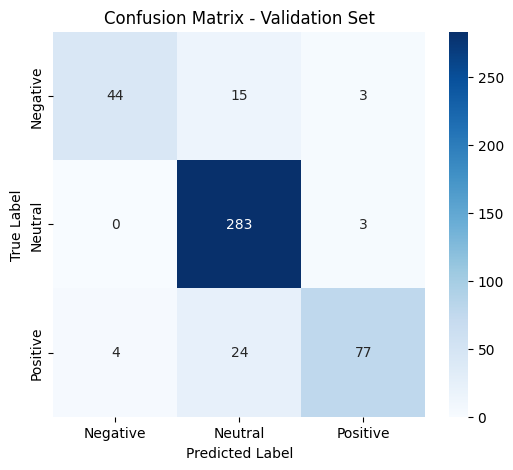

In [17]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()


In [18]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# 80% train, 10% val, 10% test
train_val = dataset["train"].train_test_split(test_size=0.2)
val_test = train_val["test"].train_test_split(test_size=0.5)

train_data = train_val["train"]
val_data = val_test["train"]
test_data = val_test["test"]

test_loader = DataLoader(
    FinancialDataset(test_data, tokenizer),
    batch_size=16,
    shuffle=False
)


Test

In [19]:
model.eval()

test_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.1362
Test Accuracy: 0.9780


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")


Precision (macro): 0.9890
Recall (macro):    0.9541
F1-score (macro):  0.9705


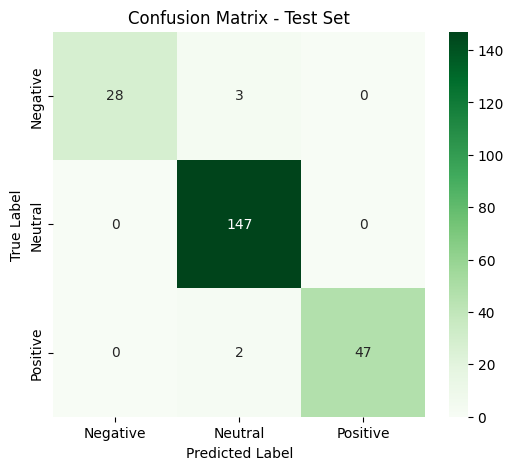

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
def visualize_attention_weights(model, tokenizer, sentences, device, num_sentences=5):
    """
    Extract attention weights from the last transformer layer and plot heatmaps.

    For each sentence, averages attention weights across all heads and plots a
    heatmap showing which tokens the model attends to when making its prediction.

    Args:
        model: Trained FinancialTransformer model
        tokenizer: BertTokenizer used to tokenize sentences
        sentences: List of raw sentence strings
        device: Device to run inference on
        num_sentences: Number of sentences to visualize (default: 5)
    """
    model.eval()
    label_names = ["Negative", "Neutral", "Positive"]

    sentences = sentences[:num_sentences]

    for idx, sentence in enumerate(sentences):
        encoding = tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            logits, attn_weights = model(input_ids, attention_mask, return_attention=True)

        predicted_class = logits.argmax(dim=1).item()
        predicted_label = label_names[predicted_class]

        # attn_weights: (1, num_heads, seq_len, seq_len) — average over heads
        avg_attn = attn_weights[0].mean(dim=0).cpu().numpy()  # (seq_len, seq_len)

        # Identify real (non-padding) tokens
        real_token_ids = attention_mask[0].cpu().numpy()
        real_len = int(real_token_ids.sum())

        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy()[:real_len])
        avg_attn_trimmed = avg_attn[:real_len, :real_len]

        fig, ax = plt.subplots(figsize=(max(8, real_len * 0.5), max(6, real_len * 0.45)))
        im = ax.imshow(avg_attn_trimmed, cmap='viridis', aspect='auto')
        plt.colorbar(im, ax=ax)

        ax.set_xticks(range(real_len))
        ax.set_yticks(range(real_len))
        ax.set_xticklabels(tokens, rotation=90, fontsize=8)
        ax.set_yticklabels(tokens, fontsize=8)

        ax.set_xlabel("Key Tokens (attended to)")
        ax.set_ylabel("Query Tokens")
        ax.set_title(
            f"Sentence {idx + 1} — Predicted: {predicted_label}\n\"{sentence[:80]}{'...' if len(sentence) > 80 else ''}\"",
            fontsize=10
        )

        plt.tight_layout()
        filename = f"attention_heatmap_sentence_{idx + 1}.png"
        plt.savefig(filename, dpi=150)
        plt.show()
        print(f"  Saved: {filename} | Prediction: {predicted_label}")

    # ===== Attention Weight Visualization =====
    print("\n" + "="*50)
    print("ATTENTION WEIGHT VISUALIZATION")
    print("="*50)
    print("Extracting attention weights from the last transformer layer...")

    test_sentences = [item['sentence'] for item in data['test_data'].select(range(5))]
    visualize_attention_weights(model, tokenizer, test_sentences, device, num_sentences=5)




In [ ]:
if __name__ == "__main__":
    all_ds = load_financial_dataset()

    # Model hyperparameters
    vocab_size = tokenizer.vocab_size     # Size of vocabulary
    embed_dim = 256         # Embedding dimension
    num_heads = 8           # Number of attention heads
    ff_dim = 1024           # Feed-forward dimension
    num_layers = 4          # Number of transformer blocks
    max_seq_len = 128       # Maximum sequence length
    num_classes = 3         # Number of output classes (Positive, Negative, Neutral)
    dropout = 0.1           # Dropout rate
    
    # Create model
    model = FinancialTransformer(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_layers=num_layers,
        max_seq_len=max_seq_len,
        num_classes=num_classes,
        dropout=dropout
    )
    
    # Example input: batch of token indices
    batch_size = 16
    seq_len = 50
    x = torch.randint(0, vocab_size, (batch_size, seq_len))
    
    # Forward pass
    output = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

    test_sentences = [item['sentence'] for item in data['test_data'].select(range(5))]
    visualize_attention_weights(model, tokenizer, test_sentences, device, num_sentences=5)


AttributeError: 'NoneType' object has no attribute 'unsqueeze'